# EDA + Model Analysis Decide 4 AI Sales Forecasting
> *By: Esteban Sánchez*
____

In [1]:
import collections
import datetime
import os
import random
import time
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, RobustScaler, StandardScaler
from sklearn.svm import SVR
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv1D, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling1D, MaxPooling2D
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans


mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
warnings.filterwarnings("ignore")

<a id = "toc"></a>
### Table Of Contents

- [1. Exploratory Data Analysis](#1.)
    * [1.1. Null Values](#1.1.)
    * [1.2. Counts](#1.2.)
    * [1.3. Tops & Bottoms Seller Products Per Year](#1.3.)
    * [1.4. Tops & Bottoms Growth Products Per Year](#1.4.)
    * [1.5. Plot Products](#1.5.)
- [2. Model Analysis](#2.)
    * [2.1. Standardize Data](#2.1.)
    * [2.2. ARIMA Based Models](#2.2.)
        + [2.2.1. Best Model](#2.2.1.)
    * [2.3. ML Based Models](#2.3.)
        + [2.3.1. ML Data Approach](#2.3.1.)
        + [2.3.2. Best Model](#2.3.2.)
    * [2.4. DL Based Models](#2.4.)
- [3. Model Selection](#3.)

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1."></a>
# 1. Exploratory Data Analysis

In [2]:
file_name = "datos_venta.csv"
data_folder = "DATA"
file_path = os.path.abspath(os.path.join("..", data_folder, file_name))

In [3]:
col_types = {
    "Producto": object, 
    "Unidades": float, 
    "Almacen": object
}

In [4]:
sales_df = pd.read_csv(file_path, sep=";", decimal=",",
                       parse_dates=["Fecha Prevista de Entrega"],
                       dtype=col_types)
sales_df.columns = [col.lower().replace(" ", "_") for col in sales_df.columns]

In [5]:
for col in ("year", "month", "day"):
    exec(f"sales_df['{col}'] = sales_df['fecha_prevista_de_entrega'].dt.{col}")
sales_df["week"] = sales_df['fecha_prevista_de_entrega'].dt.isocalendar().week

In [6]:
sales_df.head()

,fecha_prevista_de_entrega,producto,unidades,almacen,year,month,day,week
0,2017-03-24,XXLjcfd,700.0,XXA,2017,3,24,12
1,2017-04-03,XXLjcfd,125.0,XXA,2017,4,3,14
2,2017-04-04,XXLjcfd,900.0,XXA,2017,4,4,14
3,2017-04-04,XXLjcfd,750.0,XXA,2017,4,4,14
4,2017-04-07,XXLjcfd,1000.0,XXA,2017,4,7,14


In [7]:
sales_df.shape

(171372, 8)

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1.1."></a>
# 1.1. Null Values

In [8]:
sales_df.isnull().sum()

fecha_prevista_de_entrega    0
producto                     0
unidades                     0
almacen                      0
year                         0
month                        0
day                          0
week                         0
dtype: int64

We have just see that there are not null values, however, are there sales every day?

In [9]:
max_date = sales_df["fecha_prevista_de_entrega"].max()
min_date = sales_df["fecha_prevista_de_entrega"].min()

unique_dates = sales_df["fecha_prevista_de_entrega"].nunique()

if (max_date - min_date).days == unique_dates:
    print("We have sales data for every day.")
else:
    print("We do not have sales every day", "\n")
    print(f"Unique date on data: {unique_dates}\nRange between min/max date: {(max_date - min_date).days}")

We do not have sales every day 

Unique date on data: 1206
Range between min/max date: 1501


As we can see from the previous cell on our data we have less days than the range of days between min/max date

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1.2."></a>
# 1.2. Counts

In [10]:
print(f"There are {sales_df['almacen'].nunique()} different stores.")
print(f"There are {sales_df['producto'].nunique()} different products.")

There are 8 different stores.
There are 321 different products.


In [11]:
sales_df['almacen'].unique()

array(['XXA', 'XXB', 'XXC', 'XXD', 'XXG', 'XXH', 'XXI', 'XXJ'],
      dtype=object)

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1.3."></a>
# 1.3. Tops & Bottoms Seller Products Per Year

In [12]:
sales_aux = sales_df.groupby(["year", "almacen", "producto"], as_index=False)["unidades"].sum()

In [13]:
top3 = sales_aux.groupby(["year", "almacen"]).apply(lambda u: u.nlargest(3, "unidades")).reset_index(drop=True)
bot3 = sales_aux.groupby(["year", "almacen"]).apply(lambda u: u.nsmallest(3, "unidades")).reset_index(drop=True)

In [14]:
top3.sort_values(["almacen", "year", "unidades"], ascending=[True, False, False]).head(6)

,year,almacen,producto,unidades
45,2020,XXA,XXNjbji,4264448.56
46,2020,XXA,XXNjcae,2443143.00
47,2020,XXA,XXNajdh,538298.00
28,2019,XXA,XXNjbji,6946731.84
29,2019,XXA,XXNjcae,3517348.00
30,2019,XXA,XXNajdh,662076.00


In [15]:
top3.sort_values(["almacen", "year", "unidades"], ascending=[True, False, False]).tail(6)

,year,almacen,producto,unidades
25,2018,XXJ,XXNjfeb,47194.0
26,2018,XXJ,XXNjffd,33594.0
27,2018,XXJ,XXNjfec,29900.0
12,2017,XXJ,XXNjfeb,41640.0
13,2017,XXJ,XXNjffd,29652.0
14,2017,XXJ,XXNjfff,24216.0


In [16]:
bot3.sort_values(["almacen", "year", "unidades"], ascending=[True, False, False]).head(6)

,year,almacen,producto,unidades
45,2020,XXA,XXNadga,1.0
46,2020,XXA,XXNadgb,1.0
47,2020,XXA,XXNadgj,1.0
30,2019,XXA,XXNjibc,600.0
28,2019,XXA,XXNacha,12.0
29,2019,XXA,XXNachb,12.0


In [17]:
print(f"Over the {sales_df['producto'].nunique()} different products that we have on data, only {top3['producto'].nunique()} are in the top 3 sellers products per store.")
print(f"Over the {sales_df['producto'].nunique()} different products that we have on data, only {bot3['producto'].nunique()} are in the bottom 3 sellers products per store.")


Over the 321 different products that we have on data, only 20 are in the top 3 sellers products per store.
Over the 321 different products that we have on data, only 41 are in the bottom 3 sellers products per store.


So as we can see from the previous cell we will have more difference between lower seller product per store than between the top seller ones.

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1.4."></a>
# 1.4. Tops & Bottoms Growth Products Per Year

In [18]:
sales_aux = pd.pivot_table(sales_df, columns=["year"], index=["almacen", "producto"],
                           values=["unidades"], aggfunc=np.sum)

sales_aux.columns = sales_aux.columns.droplevel()
sales_aux.reset_index(inplace=True)

In [19]:
for year in (2017, 2018, 2019, 2020):
    sales_aux[f"{year}_growth"] = (sales_aux[year] - sales_aux[year - 1]).divide(sales_aux[year - 1])

In [20]:
growth_cols = [f"{year}_growth" for year in (2017, 2018, 2019, 2020)]
sales_aux["growth_mean"] = sales_aux[growth_cols].mean(axis=1)
sales_aux["growth_std"] = sales_aux[growth_cols].std(axis=1)

In [21]:
top_growth = sales_aux[sales_aux["growth_mean"] > 0]
bot_growth = sales_aux[sales_aux["growth_mean"] < 0]

In [22]:
top5 = top_growth[["almacen", "producto", "growth_mean", "growth_std"]] \
    .groupby(["almacen"]).apply(lambda u: u.nsmallest(5, "growth_std")).reset_index(drop=True)

In [23]:
bot5 = bot_growth[["almacen", "producto", "growth_mean", "growth_std"]] \
    .groupby(["almacen"]).apply(lambda u: u.nsmallest(5, "growth_std")).reset_index(drop=True)

In [24]:
top5.head(10)

year,almacen,producto,growth_mean,growth_std
0,XXA,XXNajdj,0.016703,0.048822
1,XXA,XXLjgab,0.140768,0.091316
2,XXA,XXNjbdj,0.031660,0.116699
3,XXA,XXNabje,0.416667,0.117851
4,XXA,XXNajed,0.081078,0.134313
5,XXB,XXNagbj,0.002524,0.086966
6,XXB,XXNjaid,0.079701,0.153831
7,XXB,XXNjafc,0.161932,0.253892
8,XXB,XXNjega,0.037438,0.257227
9,XXB,XXNjaic,0.044800,0.273510


In [25]:
bot5.head(10)

year,almacen,producto,growth_mean,growth_std
0,XXA,XXNabaf,-0.054782,0.110167
1,XXA,XXNjaad,-0.064261,0.115205
2,XXA,XXNjahf,-0.405544,0.115944
3,XXA,XXNabib,-0.158333,0.129636
4,XXA,XXNjaid,-0.284767,0.133908
5,XXB,XXNajjb,-0.360845,0.055939
6,XXB,XXNjhef,-0.081787,0.090149
7,XXB,XXNjbci,-0.077035,0.129531
8,XXB,XXNjiha,-0.090581,0.129771
9,XXB,XXNjagd,-0.335481,0.151724


<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "1.5."></a>
# 1.5. Plot Products

In [26]:
def plot_product_by_store(df, product, store):
    """Plot sells of a product per store, the total of selling and mean across the stores.
    
    Parameters
    ----------
        df pd.DataFrame:
            Object with the data to plot.
        
        product str:
            String which corresponds with the product we want to plot.
        
        store str:
            String which corresponds with the store we want to highlight in the plot.
            
    Returns
    -------
        None
        
    """
    # Create a figure with a fixed size.
    my_dpi=96
    plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)
    
    # Preprocess data to be the input of the plot.
    df = df[df["producto"] == product]
    df = df.groupby(["year", "month", "almacen"], as_index=False)["unidades"].sum()
    df = df.astype({"year": str, "month": str})
    df["month_sales"] = df["year"] + "-" + df["month"] + "-01"
    df['month_sales'] = pd.to_datetime(df['month_sales'], errors='coerce').dropna()
    df.sort_values("month_sales", ascending=True, inplace=True)
    mean_store_df = df.groupby(["month_sales"], as_index=False)["unidades"].agg(["sum", "mean"])
    df = df[df["almacen"] == store]
    df_tot = pd.merge(left=df, right=mean_store_df, how="right", on="month_sales")
    df_tot["unidades"].fillna(0, inplace=True)
    
    # Create labels for xticks.
    labels = [str(e.year)[-2:] + "/" + str(e.month) if idx % 5 == 0 else "" for idx, e in enumerate(df_tot['month_sales'])]
    
    # Plot stackplot with the products of the store and the total across stores.
    plt.stackplot(df_tot['month_sales'], df_tot['unidades'], df_tot["sum"], colors=["#FF8206", "#CACACA"], alpha=.6)
    
    # Plot the mean of sells across stores.
    plt.plot(df_tot['month_sales'], df_tot['mean'], marker='', color='#6600E6', linewidth=2, alpha=1)
    
    # Customize the graph.
    plt.xticks(list(df_tot['month_sales'].unique()), labels);
    plt.ylabel("Units");
    plt.tick_params(bottom=False, left=False);
    plt.legend(["Mean Sells", store, "Total Sells"], loc="upper right", frameon=False, labelcolor="linecolor")
    plt.title(f"Product: {product}\n")

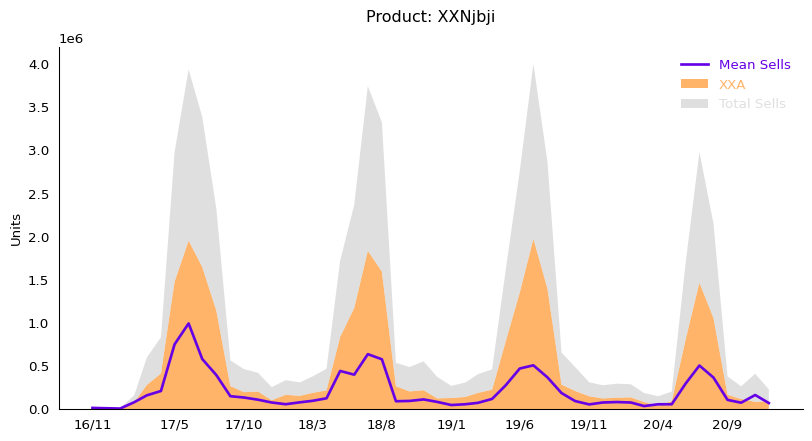

In [27]:
plot_product_by_store(sales_df, "XXNjbji", "XXA")

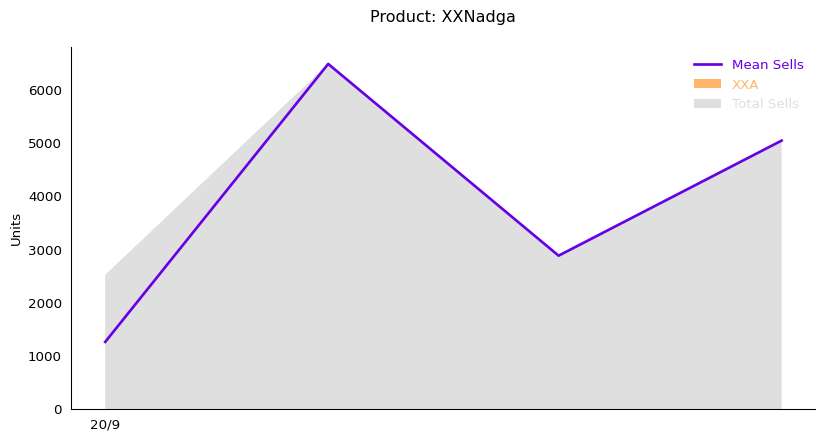

In [28]:
plot_product_by_store(sales_df, "XXNadga", "XXA")

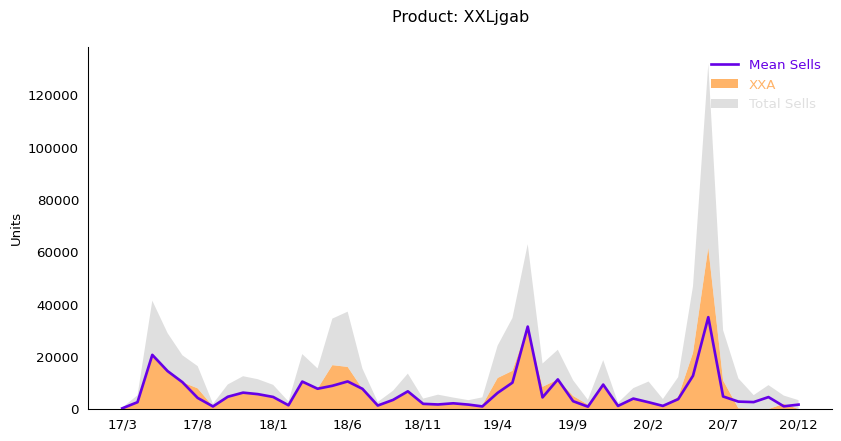

In [29]:
plot_product_by_store(sales_df, "XXLjgab", "XXA")

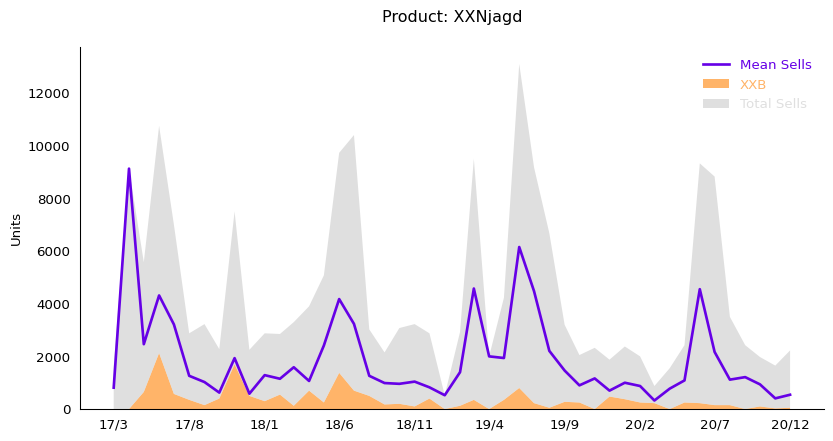

In [30]:
plot_product_by_store(sales_df, "XXNjagd", "XXB")

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2."></a>
# 2. Model Analysis

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.1."></a>
# 2.1. Standardize Data

Due to the goal is to forecast the demand of the following 8 weeks we have to group by our data in weeks

In [31]:
def get_last_day_of_week(day):
    """Return last day of the week for a given day.
    
    Parameters
    ----------
        day datetime.date:
            Day to calculate last day of week.
    
    Returns
    -------
        datetime.date:
            Last day of the week for the corresponding day.
    """
    
    return day + datetime.timedelta(days=6 - day.weekday())

In [32]:
sales_df["last_weekday"] = sales_df["fecha_prevista_de_entrega"].apply(get_last_day_of_week)

In [33]:
df = sales_df.groupby(["last_weekday", "almacen", "producto"], as_index=False)["unidades"].sum()
df.shape

(36498, 4)

In [34]:
df = df.sort_values("last_weekday").reset_index(drop=True)

In [35]:
df.tail(3)

,last_weekday,almacen,producto,unidades
36495,2021-01-03,XXD,XXNabcb,9606.0
36496,2021-01-03,XXD,XXNabai,20.0
36497,2021-01-03,XXJ,XXNjfff,144.0


As we can see from section [1.1. Null Values](#1.1.) there are empty days, so let's get deeper in that fact.

In [36]:
weekly_date_range = pd.date_range(df["last_weekday"].min(), df["last_weekday"].max(), freq='W-SUN')

In [37]:
print(f"Total number of end of weeks: {len(weekly_date_range)}")
print(f"Total number of end of weeks in our data: {df['last_weekday'].nunique()}")

Total number of end of weeks: 215
Total number of end of weeks in our data: 211


In [38]:
[e for e in weekly_date_range if e not in df["last_weekday"].unique()]

[Timestamp('2016-12-11 00:00:00', freq='W-SUN'),
 Timestamp('2016-12-18 00:00:00', freq='W-SUN'),
 Timestamp('2016-12-25 00:00:00', freq='W-SUN'),
 Timestamp('2017-01-01 00:00:00', freq='W-SUN')]

In [39]:
df.head()

,last_weekday,almacen,producto,unidades
0,2016-11-27,XXA,XXNjbji,3757.0
1,2016-12-04,XXA,XXNjbji,9594.0
2,2017-01-08,XXA,XXNjcae,4400.0
3,2017-01-15,XXA,XXNjbji,1240.0
4,2017-01-15,XXA,XXNjgag,12480.0


As we can see from the latest 2 cells the weeks we do not have in our data are latest days of 2016 and first week of 2017. We are going to going on with the data up to 2017-01-08 in order to solve this because dropping ancient dates will remove less that a 1% of the weeks, as we can see in the following cell.

In [40]:
print(100 * df[df["last_weekday"] < "2017-01-08"]["last_weekday"].nunique() / df["last_weekday"].nunique())

0.9478672985781991


In [41]:
df = df[df["last_weekday"] >= "2017-01-08"]
df.shape

(36496, 4)

In [42]:
df.head()

,last_weekday,almacen,producto,unidades
2,2017-01-08,XXA,XXNjcae,4400.0
3,2017-01-15,XXA,XXNjbji,1240.0
4,2017-01-15,XXA,XXNjgag,12480.0
5,2017-01-22,XXB,XXNjefh,800.0
6,2017-01-22,XXA,XXNjbji,967.0


Because of our data is weekly we want to calculate the forecasting to the following 10 steps (10 weeks ~ 2 months). Specifically we want to calculate the months of January and February of 2021 so we have to drop our data from that date.

In order to choose the best model we have to make a cross validation considering the time, for this case test size is going to be 10 weeks and we are going to compute 5 folds.

In [43]:
df_2021 = df[df["last_weekday"].dt.year == 2021]
df = df[df["last_weekday"].dt.year < 2021]

In [44]:
dummies = pd.concat([pd.get_dummies(df["almacen"]), pd.get_dummies(df["producto"])], axis=1)
dummies.head()

,XXA,XXB,XXC,XXD,XXG,XXH,XXI,XXJ,XXLjcfd,XXLjgab,...,XXNjiie,XXNjjdf,XXNjjeh,XXNjjfc,XXNjjfd,XXNjjff,XXNjjfj,XXNjjgc,XXNjjgd,XXNjjha
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
folds = []
for i in range(5):
    train_dates = df["last_weekday"].unique()[:-14 + i]
    test_dates = df["last_weekday"].unique()[-14 + i:][:10]
    
    train = df[df["last_weekday"].isin(train_dates)]
    test = df[df["last_weekday"].isin(test_dates)]
    
    train_exo = dummies[dummies.index.isin(train.index)]
    test_exo = dummies[dummies.index.isin(test.index)]
    folds.append((train, train_exo, test, test_exo))

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.2."></a>
# 2.2. ARIMA Based Models

Before apply an ARIMA model we have to calculate a grid of possible values of (p, q, d) to the model. In order to do that we would have to study each timeseries (per store and product) to infer a possible grid, due to the time consuming about this analysis I propose to clusterize timeseries to extract one representative timeseries on each cluster and analyse that one as representation of the cluster in order to reduce time of analysing.

In [49]:
stores = df["almacen"].unique()
products = df["producto"].unique()

In [50]:
# Create an array of shape (number_of_ts, size_of_ts)
my_series = []
for store in stores:
    for product in products:
        aux = df[(df["almacen"] == store) & (df["producto"] == product)]
        if not aux.empty:
            aux = aux[["last_weekday", "unidades"]]
            aux = aux.set_index("last_weekday")
            aux = aux.rename(columns = {"unidades": f"{store}_{product}"})
            my_series.append(aux[f"{store}_{product}"])
            
data = pd.concat(my_series, axis=1)
data.fillna(0, inplace=True)
data = data.T.values

# Apply a min max scaler over data
min_max = MinMaxScaler()
data_scaler = min_max.fit_transform(data)

Inertia calculated for 2 clusters.
Inertia calculated for 3 clusters.
Inertia calculated for 4 clusters.
Inertia calculated for 5 clusters.
Inertia calculated for 6 clusters.


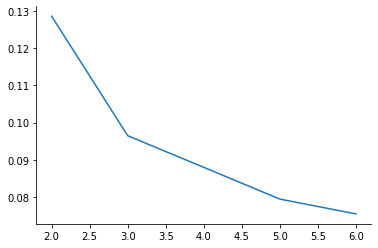

In [47]:
# Calculate number of cluster based on 'elbow method'
inertia = []
for n in range(2, 7):
    ts = TimeSeriesKMeans(n_clusters=n, metric="dtw")
    ts.fit(data_scaler)
    inertia.append(ts.inertia_)
    print(f"Inertia calculated for {n} clusters.")

plt.plot(range(2, 7), inertia);

In [51]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
labels = ts_kmeans.fit_predict(data_scaler)

In [52]:
elements_count = collections.Counter(labels)
elements_count

Counter({2: 39, 0: 1031, 1: 66})

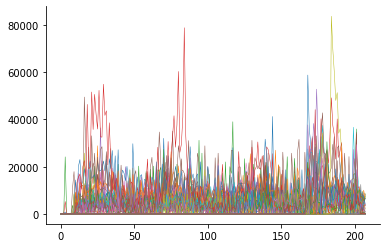

In [53]:
# An example of groupping
for i in range(data.shape[0]):
    if labels[i] == 1:
        plt.plot(data[i, :], alpha=1, linewidth=.5)

To study the timeseries let's extract the most representative by calculate the distance to the centroid

In [54]:
label0 = []
label1 = []
label2 = []

for i in range(data.shape[0]):
    zeros = data[i, :]
    if (zeros == 0).sum() / zeros.shape[0] >= .2:
        continue
        
    if labels[i] == 0:
        cluster_center = ts_kmeans.cluster_centers_[0]
        values = data_scaler[i, :].reshape(-1, 1)
        label0.append((i, dtw(values, cluster_center)))
    elif labels[i] == 1:
        cluster_center = ts_kmeans.cluster_centers_[1]
        values = data_scaler[i, :].reshape(-1, 1)
        label1.append((i, dtw(values, cluster_center)))
    else:
        cluster_center = ts_kmeans.cluster_centers_[2]
        values = data_scaler[i, :].reshape(-1, 1)
        label2.append((i, dtw(values, cluster_center)))

label0.sort(key=lambda _: _[1])
label1.sort(key=lambda _: _[1])
label2.sort(key=lambda _: _[1])

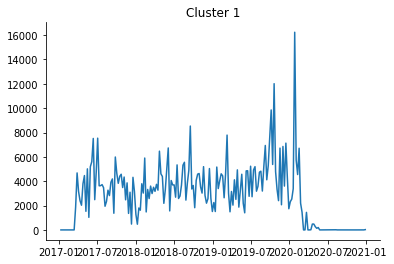

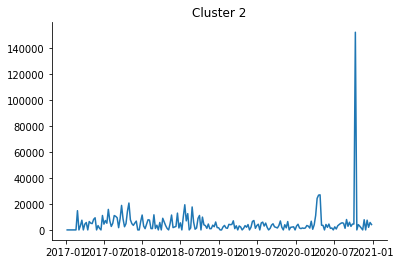

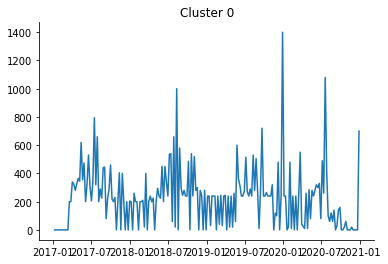

In [55]:
choosen_idx = {label0[0][0]: "0", label1[0][0]: "1", label2[0][0]: "2"}
ts = {"last_weekday": df["last_weekday"].unique()}
for i in range(data.shape[0]):
    if i in choosen_idx.keys():
        ts = {**ts, **{f"Cluster {choosen_idx.get(i)}": data[i, :]}}
        plt.figure()
        plt.plot(df["last_weekday"].unique(), data[i, :])
        plt.title(f"Cluster {choosen_idx.get(i)}")

In [56]:
df_clusters = pd.DataFrame(ts)
df_clusters.set_index("last_weekday", inplace=True)
df_clusters.head(5)

,Cluster 1,Cluster 2,Cluster 0
last_weekday,,,
2017-01-08,0.0,0.0,0.0
2017-01-15,0.0,0.0,0.0
2017-01-22,0.0,0.0,0.0
2017-01-29,0.0,0.0,0.0
2017-02-05,0.0,0.0,0.0


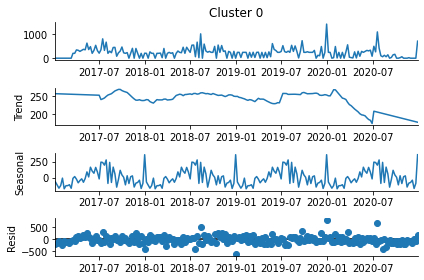

In [57]:
add = seasonal_decompose(df_clusters['Cluster 0'], model='additive', extrapolate_trend='freq')
add.plot();

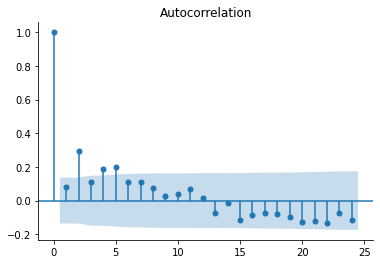

In [58]:
plot_acf(df_clusters["Cluster 0"]);

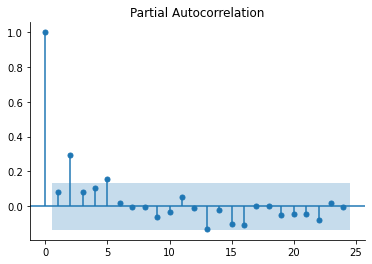

In [59]:
plot_pacf(df_clusters["Cluster 0"]);

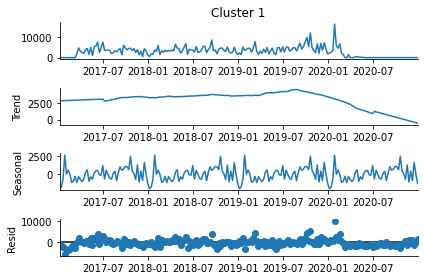

In [60]:
add = seasonal_decompose(df_clusters['Cluster 1'], model='additive', extrapolate_trend='freq')
add.plot();

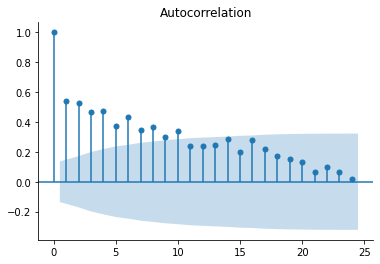

In [61]:
plot_acf(df_clusters["Cluster 1"]);

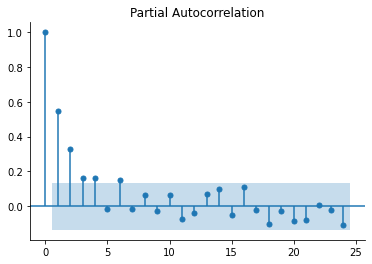

In [62]:
plot_pacf(df_clusters["Cluster 1"]);

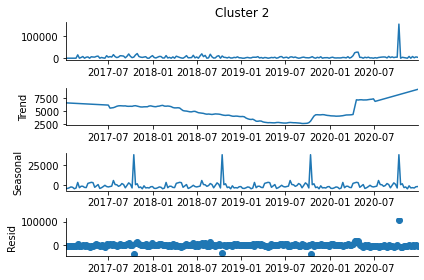

In [63]:
add = seasonal_decompose(df_clusters['Cluster 2'], model='additive', extrapolate_trend='freq')
add.plot();

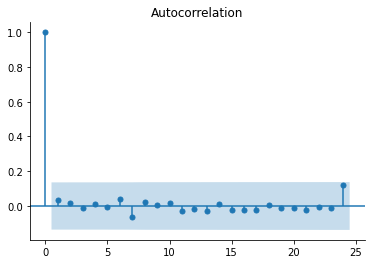

In [64]:
plot_acf(df_clusters["Cluster 2"]);

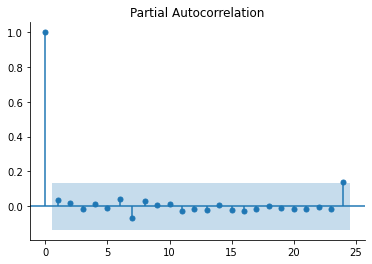

In [65]:
plot_pacf(df_clusters["Cluster 2"]);

From time series analysis of PACF and ACF with seasonality decomposition we can test ARIMA with p = (0, 1, 2, 3, 4, 5), d = (0, 1, 2), q = (0, 1, 2, 3, 4, 5)

In [66]:
max_d = 2
max_p = 3
max_q = 3

option_orders = []
for d in list(range(max_d + 1)):
    for p in list(range(max_p + 1)):
        for q in list(range(max_q + 1)):
            option_orders.append((p, d, q))

In [67]:
train_fold = folds[-1]

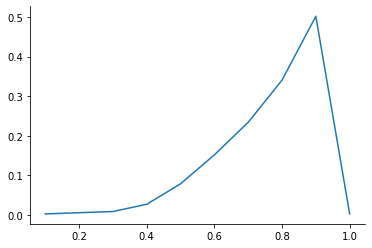

In [65]:
n_cols = []
for p in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    pca = PCA(p)
    data_aux = pca.fit_transform(train_fold[1].values)
    n_cols.append(data_aux.shape[1]/train_fold[1].values.shape[1])
    
plt.plot([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1], n_cols);

In [66]:
print(f"Total of options: {len(option_orders)}")

Total of options: 48


In [67]:
pca_factor = .9
aics = list()
pca = PCA(pca_factor)
data_aux = pca.fit_transform(train_fold[1].values)
for idx, order in enumerate(option_orders):
    ti = time.time()
    mod = ARIMA(train_fold[0]["unidades"].values, exog=data_aux, order=order)
    
    try:
        res = mod.fit()
        aics.append([order, res.aic])
    except:
        aics.append(None)
        continue
    if idx % 5 == 0:
        print(f"Option number {idx} with params {order}")
        print(f"Train time {time.time() - ti}")

Option number 0 with params (0, 0, 0)
Train time 57.56220841407776
Option number 5 with params (1, 0, 1)
Train time 363.0731828212738
Option number 10 with params (2, 0, 2)
Train time 158.0626835823059
Option number 15 with params (3, 0, 3)
Train time 360.38366651535034
Option number 20 with params (1, 1, 0)
Train time 106.1400191783905
Option number 25 with params (2, 1, 1)
Train time 573.8834066390991
Option number 30 with params (3, 1, 2)
Train time 185.17398762702942
Option number 35 with params (0, 2, 3)
Train time 482.02192878723145
Option number 40 with params (2, 2, 0)
Train time 70.7856011390686
Option number 45 with params (3, 2, 1)
Train time 690.4308180809021


In [68]:
aics.sort(key=lambda e: e[1])
k = 10
topk = aics[:k]

In [69]:
topk

[[(1, 0, 3), 746236.6922494464],
 [(1, 0, 2), 746237.1079989339],
 [(0, 0, 3), 746238.2349826116],
 [(2, 0, 2), 746238.334342403],
 [(3, 0, 0), 746239.3738333477],
 [(3, 0, 2), 746240.0488445924],
 [(2, 0, 1), 746240.2373371193],
 [(2, 0, 3), 746240.6270423823],
 [(3, 0, 1), 746241.2890650298],
 [(3, 0, 3), 746241.7856699458]]

In [70]:
params = {}
for order in topk:
    ti = time.time()
    folds_rmse = []
    for kfold in folds:
        train = kfold[0]
        train_exo = kfold[1]
        test = kfold[2]
        test_exo = kfold[3]

        pca = PCA(pca_factor)
        train_exo_reduced = pca.fit_transform(train_exo)
        test_exo_reduced = pca.transform(test_exo)

        model = ARIMA(train["unidades"].values, exog=train_exo_reduced, order=order[0])
        model_fit = model.fit()
        forecasting = model_fit.forecast(test_exo_reduced.shape[0], exog=test_exo_reduced)
        rmse = np.sqrt(mean_squared_error(test["unidades"].values, forecasting))
        folds_rmse.append(rmse)
        
    mean_folds = np.mean(folds_rmse)
    std_folds = np.std(folds_rmse)
    
    params[str(order[0])] = [mean_folds, std_folds]
    print(f"Finish parameters {order[0]} in {time.time() - ti}")

Finish parameters (1, 0, 3) in 296.96293592453003
Finish parameters (1, 0, 2) in 259.50626134872437
Finish parameters (0, 0, 3) in 269.4891860485077
Finish parameters (2, 0, 2) in 266.7961986064911
Finish parameters (3, 0, 0) in 218.5540919303894
Finish parameters (3, 0, 2) in 306.9546592235565
Finish parameters (2, 0, 1) in 426.4769706726074
Finish parameters (2, 0, 3) in 409.9031946659088
Finish parameters (3, 0, 1) in 599.5354378223419
Finish parameters (3, 0, 3) in 723.5334641933441


In [71]:
params

{'(1, 0, 3)': [8630.02840573501, 435.90241368456407],
 '(1, 0, 2)': [8630.071697684236, 435.95583542559535],
 '(0, 0, 3)': [8630.089626275429, 435.9785312338021],
 '(2, 0, 2)': [8630.040744359489, 435.9184550048784],
 '(3, 0, 0)': [8629.97819806798, 435.8421957802161],
 '(3, 0, 2)': [8630.046530279167, 435.921248010795],
 '(2, 0, 1)': [8629.971292102056, 435.83584988427043],
 '(2, 0, 3)': [8630.0329936133, 435.90981523592853],
 '(3, 0, 1)': [8630.013176853497, 435.8830884487636],
 '(3, 0, 3)': [8630.045539118812, 435.91913520204497]}

As we can see from the previous cell best model in terms of RMSE is with (2, 0, 1) parameters

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.2.1."></a>
# 2.2.1. Best Model

In [70]:
arima_train = folds[-1][0]
arima_train_exo = folds[-1][1]
arima_test = folds[-1][2]
arima_test_exo = folds[-1][3]

pca = PCA(.9)
arima_train_exo_reduced = pca.fit_transform(arima_train_exo)
arima_test_exo_reduced = pca.transform(arima_test_exo)

arima_model = ARIMA(arima_train["unidades"].values, exog=arima_train_exo_reduced, order=(2, 0, 1))
arima_model_fit = arima_model.fit()
forecasting = arima_model_fit.forecast(arima_test_exo_reduced.shape[0], exog=arima_test_exo_reduced)
arima_test["forecasting"] = forecasting
rmse = np.sqrt(mean_squared_error(arima_test["unidades"].values, forecasting))

In [46]:
def f_rmse(item):
    """Function to apply rmse over a groupby."""
    return np.sqrt(mean_squared_error(item["unidades"].values, item["forecasting"].values))

In [71]:
arima_test.groupby("last_weekday").apply(f_rmse)

last_weekday
2020-10-25    7740.426095
2020-11-01    7942.219469
2020-11-08    7818.611334
2020-11-15    8961.285068
2020-11-22    9616.323560
2020-11-29    8717.671066
2020-12-06    8026.329732
2020-12-13    7333.498265
2020-12-20    7040.766109
2020-12-27    7790.008791
dtype: float64

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.3."></a>
# 2.3. ML Based Models

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.3.1."></a>
# 2.3.1. ML Data Approach

In [47]:
def reindex_by_date(df, is_train=True):
    """Standardize all stores and product with the same date range.
    
    Parameters
    ----------
        df pd.DataFrame:
            Data to reindex.
        
        is_train bool:
            Parameter to control if the 'df' argument is training data or test. Training by default.
    
    Returns
    -------
        pd.DataFrame:
            Dataframe reindexed.
            
    """
    if is_train:
        return df.reindex(weekly_date_range_train, fill_value=0)
    else:
        return df.reindex(weekly_date_range_test, fill_value=0)

In [48]:
# We have to change the data format on the folds by other that can fit to a ML approach
new_folds = []
for train_fold in folds:
    
    train = train_fold[0]
    test = train_fold[2]
    
    # Create date range for train and test and reindex data in order to have all stores and products with the same range.
    weekly_date_range_train = pd.date_range(train["last_weekday"].min(), train["last_weekday"].max(), freq='W-SUN')
    weekly_date_range_test = pd.date_range(test["last_weekday"].min(), test["last_weekday"].max(), freq='W-SUN')
    train_aux = train.set_index("last_weekday")
    test_aux = test.set_index("last_weekday")
    train_aux = train_aux.groupby(["almacen", "producto"]).apply(reindex_by_date)
    test_aux = test_aux.groupby(["almacen", "producto"]).apply(reindex_by_date, is_train=False)
    train_aux = train_aux.drop(axis=1, labels=["almacen", "producto"])
    test_aux = test_aux.drop(axis=1, labels=["almacen", "producto"])
    train_aux = train_aux.reset_index()
    test_aux = test_aux.reset_index()
    train_aux = train_aux.rename(columns={"level_2": "last_weekday"})
    test_aux = test_aux.rename(columns={"level_2": "last_weekday"})

    # In order to apply correctly the lags over the data and avoid to create extra NaN on test set we need to append both of them
    # to calculate the lags.
    split_date = train_aux["last_weekday"].max()
    df_data = pd.concat([train_aux, test_aux])
    for nlag in range(1, 13):
        exec(f"df_data['lag{nlag}'] = df_data.groupby(['almacen', 'producto'], as_index=False)['unidades'].shift({nlag})")
        
    # Split again the train and test set with lags columns.
    train_aux = df_data[df_data["last_weekday"] <= split_date]
    test_aux = df_data[df_data["last_weekday"] > split_date]
    
    # To deal with stores and products we have to apply a OneHotEncoder.
    onehot_store = OneHotEncoder(handle_unknown="ignore")
    onehot_product = OneHotEncoder(handle_unknown="ignore")
    train_exog_store_enc = onehot_store.fit_transform(train_aux["almacen"].values.reshape(-1, 1))
    train_exog_product_enc = onehot_product.fit_transform(train_aux["producto"].values.reshape(-1, 1))
    test_exog_store_enc = onehot_store.transform(test_aux["almacen"].values.reshape(-1, 1))
    test_exog_product_enc = onehot_product.transform(test_aux["producto"].values.reshape(-1, 1))
    
    # Change data type to np.int8 becase the values are 0 and 1 and this reduce the memory usage.
    train_exog_store_enc = pd.DataFrame(data=train_exog_store_enc.toarray(), columns=onehot_store.get_feature_names(), dtype=np.int8)
    train_exog_product_enc = pd.DataFrame(data=train_exog_product_enc.toarray(), columns=onehot_product.get_feature_names(), dtype=np.int8)
    test_exog_store_enc = pd.DataFrame(data=test_exog_store_enc.toarray(), columns=onehot_store.get_feature_names())
    test_exog_product_enc = pd.DataFrame(data=test_exog_product_enc.toarray(), columns=onehot_product.get_feature_names())
    train_exog = pd.concat([train_exog_store_enc, train_exog_product_enc], axis=1)
    test_exog = pd.concat([test_exog_store_enc, test_exog_product_enc], axis=1)
    # Create the new folds with train lags, exog train columns and the same for test.
    new_folds.append((train_aux, train_exog, test_aux, test_exog))

In [49]:
# This just join the exog variables with the lags variables.
kfolds = []
for nfold in new_folds:
    train = nfold[0]
    train_exog = nfold[1]
    test = nfold[2]
    test_exog = nfold[3]
    train = pd.concat([train, train_exog], axis=1)
    test = pd.concat([test, test_exog], axis=1)
    train = train.dropna()
    test = test.dropna()
    
    # Create new folds just with train and test variables
    kfolds.append((train, test))

In [50]:
# This is the format for a ML approach
kfolds[-1][0].head(2)

,almacen,producto,last_weekday,unidades,lag1,lag2,lag3,lag4,lag5,lag6,...,x0_XXNjiie,x0_XXNjjdf,x0_XXNjjeh,x0_XXNjjfc,x0_XXNjjfd,x0_XXNjjff,x0_XXNjjfj,x0_XXNjjgc,x0_XXNjjgd,x0_XXNjjha
12,XXA,XXLjcfd,2017-04-02,0.0,700.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13,XXA,XXLjcfd,2017-04-09,2775.0,0.0,700.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
def modelling(model, X, Y, col_lags, col_dummies, options=1, poly=False):
    """Function to create a model pipeline and fit.
    
    This function takes a given model and create a pipeline for the data, there are 6
    possible choices to the lags columns: it can use a scaler between MinMaxScaler, RobustScaler
    and StandardScaler and then it can generate polynomial features with only interaction
    to then choose the 12 top features between lags and polynomial features. For the 
    dummies columns we apply a PCA keeping the 90% of variability to reduce the size of the data.
    
    Parameters
    ----------
        model:
            Model to fit.
        
        X pd.DataFrame:
            Train data.
        
        Y pd.DataFrame: 
            Target data.
        
        col_lags list:
            Names of the lags columns.
            
        col_dummies list:
            Names of the dummies columns.
            
        options int:
            1 means to apply MinMaxScaler, 2 RobustScaler, 3 StandardScaler.
        
        poly bool:
            True means to apply polynomial features with degree 2 and select 12 best. False not.
    
    Returns
    -------
        sklearn.pipeline.Pipeline:
            Fitted pipeline with the selected choices.
            
    """
    if options == 1:
        scaler = MinMaxScaler((0, 10))
        option_steps = [("scaler_lags", scaler)]
    elif options == 2:
        scaler = RobustScaler()
        option_steps = [("scaler_lags", scaler)]
    elif options == 3:
        scaler = StandardScaler()
        option_steps = [("scaler_lags", scaler)]
    
    if poly:
        polynomial = PolynomialFeatures(2, interaction_only=True)
        option_steps.append(("poly_lags", polynomial))
        selectkbest = SelectKBest(f_regression, k=12)
        option_steps.append(("selectkbest", selectkbest))
    
    pca = PCA(.9)

    lags_pipe = Pipeline(steps=option_steps)
    
    dummies_pipe = Pipeline(steps=[
        ("pca_dummies", pca)
    ])
    processor = ColumnTransformer(
        transformers=[
            ("lags_pipe", lags_pipe, col_lags),
            ("dummies_pipe", dummies_pipe, col_dummies)
        ]
    )

    pipe = Pipeline(steps=[
        ("processor", processor),
        ("model", model)
    ])
    pipe.fit(X, Y)
    return pipe

def forecast(model, test, exog_cols):
    """Forecast time steps one by one.
    
    The proccess of forecasting in a ml approach is to predict next step time
    and the use this as a lag for the following steps.
    
    Parameters
    ----------
        model sklearn.pipeline.Pipeline:
            Fitted pipeline to predict next time step.
        
        test pd.DataFrame:
            Data used to test a model.
        
        exog_cols list:
            columns used as features in the model.
    
    Returns
    -------
        pd.DataFrame:
            Data with a 'forecasting' column that takes into account the steps time.
    
    """
    # Generate data range as steps time to forecast
    test_range = test["last_weekday"].unique()
    
    # Generate a empty list to fill with the lags for the following steps.
    lags = []
    
    # Generate a empty list to fill with the forecasting
    forecasted_df = []
    
    # For loop to predict each step time one by one
    for forecasting_step, date in enumerate(test_range):
        aux = test[test["last_weekday"] == date]
        if forecasting_step != 0:
            # In this step we are changing the lags of the following steps time 
            # with the previous forecasting.
            for lag_item in lags[:10]:
                aux[col_lags] = aux[col_lags].shift(axis="columns")
                aux[f"lag1"] = lag_item
                
        forecasting = model.predict(aux[exog_cols])
        
        # Insert the forecasting into the lags list at the begining becase at each
        # step time lags move one step time.
        lags.insert(0, forecasting)
        aux["forecasting"] = forecasting
        forecasted_df.append(aux)
        
    return pd.concat(forecasted_df)
    
def execute_model(model_object, option, is_poly, kfolds, returns=False):
    """Function to execute automatically a cross validation over the folds.
    
    Parameters
    ----------
        model_object:
            Choosen model to fit.
        
        option int:
            1 means to apply MinMaxScaler, 2 RobustScaler, 3 StandardScaler.
        
        is_poly bool:
            True means to apply polynomial features with degree 2 and select 12 best. False not.
        
        kfolds list:
            Folds to apply cross validation.
        
        returns bool:
            True means to return the model.
    
    Returns
    -------
        dict:
            dictionary with model name as a key and as a value a list with the mean, std
            of the rmse one each step time across folds, mean and std on train step 
            across folds and mean and std of one step time test across folds.
    
    """
    train_rmse = []
    test_rmse = []
    rmse = []
    for fold in kfolds:
        train = fold[0]
        test = fold[1]

        col_stores = [f"x0_{store}" for store in train["almacen"].unique()]
        col_products = [f"x0_{product}" for product in train["producto"].unique()]

        mdl = modelling(model_object, train[col_lags + col_stores + col_products], train[col_target], 
                        col_lags, col_stores + col_products, options=option, poly=is_poly)
        one_step_fcast_train = mdl.predict(train[col_lags + col_stores + col_products])
        one_step_fcast_test = mdl.predict(test[col_lags + col_stores + col_products])
        
        train_rmse.append(np.sqrt(mean_squared_error(train[col_target].values, one_step_fcast_train)))
        test_rmse.append(np.sqrt(mean_squared_error(test[col_target].values, one_step_fcast_test)))

        fcast = forecast(mdl, test, col_lags + col_stores + col_products)

        rmse.append(np.sqrt(mean_squared_error(fcast[col_target].values, fcast["forecasting"].values)))
        
    return {f"{model_object.__str__()} {option} {is_poly}": [np.mean(rmse), np.std(rmse),
                                                             np.mean(train_rmse), np.std(train_rmse),
                                                             np.mean(test_rmse), np.std(test_rmse),
                                                             fcast if returns else None,
                                                             mdl if returns else None]}

In [52]:
col_target = ["unidades"]
col_lags = [f"lag{n}" for n in range(1, 13)]

In [ ]:
models = [
    Lasso(),
    Ridge(),
    KNeighborsRegressor(n_jobs=-1),
    RandomForestRegressor(n_estimators=50, n_jobs=-1),
    LGBMRegressor(n_estimators=50, n_jobs=-1),
    LinearRegression(n_jobs=-1)
]

In [ ]:
summary = {}
for option in [1, 2, 3]:
    for pol in [True, False]:
        for model in models:
            ti = time.time()
            summary = {**summary, **execute_model(model, option, pol, kfolds)}
            print("#"*10)
            print(f"{model.__str__()} in time {time.time() - ti}")

In [ ]:
sorted(summary.items(), key=lambda item: item[1][0])

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.3.2."></a>
# 2.3.2. Best Model

Let's try to improve the top 3 models by searching the hyperparameters (LGBMRegressor, Ridge, KNN)

In [57]:
models = [
    (Ridge(alpha=1), 1, True),
    (Ridge(alpha=.1), 1, True),
    (Ridge(alpha=.01), 1, True),
    
    (KNeighborsRegressor(n_neighbors=5, weights="uniform", p=2, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=5, weights="distance", p=2, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=10, weights="uniform", p=2, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=10, weights="distance", p=2, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=5, weights="uniform", p=1, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=5, weights="distance", p=1, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=10, weights="uniform", p=1, n_jobs=-1), 2, True),
    (KNeighborsRegressor(n_neighbors=10, weights="distance", p=1, n_jobs=-1), 2, True),
    
    (LGBMRegressor(n_estimators=10, max_depth=-1, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=10, max_depth=100, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=10, max_depth=10, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=50, max_depth=-1, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=50, max_depth=100, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=50, max_depth=10, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=100, max_depth=-1, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=100, max_depth=100, n_jobs=-1), 1, True),
    (LGBMRegressor(n_estimators=100, max_depth=10, n_jobs=-1), 1, True),
]

In [58]:
summary = {}
for model in models:
    ti = time.time()
    summary = {**summary, **execute_model(model[0], model[1], model[2], [kfolds[-1]])}
    print("#"*10)
    print(f"{model.__str__()} in time {time.time() - ti}")

##########
(Ridge(alpha=1), 1, True) in time 15.741120338439941
##########
(Ridge(alpha=0.1), 1, True) in time 15.68693733215332
##########
(Ridge(alpha=0.01), 1, True) in time 16.202861070632935
##########
(LGBMRegressor(n_estimators=10), 1, True) in time 18.34155535697937
##########
(LGBMRegressor(max_depth=100, n_estimators=10), 1, True) in time 18.412397861480713
##########
(LGBMRegressor(max_depth=10, n_estimators=10), 1, True) in time 18.254605054855347
##########
(LGBMRegressor(n_estimators=50), 1, True) in time 20.46045160293579
##########
(LGBMRegressor(max_depth=100, n_estimators=50), 1, True) in time 20.290299654006958
##########
(LGBMRegressor(max_depth=10, n_estimators=50), 1, True) in time 20.523415327072144
##########
(LGBMRegressor(), 1, True) in time 21.470739126205444
##########
(LGBMRegressor(max_depth=100), 1, True) in time 21.933034896850586
##########
(LGBMRegressor(max_depth=10), 1, True) in time 23.038252115249634


In [59]:
sorted(summary.items(), key=lambda item: item[1][0])

[('LGBMRegressor(max_depth=10) 1 True',
  [3780.102840479635,
   0.0,
   2371.95346433867,
   0.0,
   4106.581778957843,
   0.0,
   None,
   None]),
 ('LGBMRegressor(max_depth=10, n_estimators=50) 1 True',
  [3790.98850929104,
   0.0,
   2495.033278355432,
   0.0,
   4033.2994485489958,
   0.0,
   None,
   None]),
 ('LGBMRegressor() 1 True',
  [3809.0317564432994,
   0.0,
   2357.4862359312942,
   0.0,
   4093.178934462813,
   0.0,
   None,
   None]),
 ('LGBMRegressor(max_depth=100) 1 True',
  [3809.0317564432994,
   0.0,
   2357.4862359312942,
   0.0,
   4093.178934462813,
   0.0,
   None,
   None]),
 ('LGBMRegressor(n_estimators=50) 1 True',
  [3817.5601962556107,
   0.0,
   2499.0399831887858,
   0.0,
   3998.6601462597764,
   0.0,
   None,
   None]),
 ('LGBMRegressor(max_depth=100, n_estimators=50) 1 True',
  [3817.5601962556107,
   0.0,
   2499.0399831887858,
   0.0,
   3998.6601462597764,
   0.0,
   None,
   None]),
 ('Ridge(alpha=1) 1 True',
  [3953.6875432150728,
   0.0,
   260

as we can see from the previous cell best model is 'LGBMRegressor(max_depth=10) 1 True'. 

In [61]:
models = [
    (LGBMRegressor(n_estimators=100, max_depth=10, n_jobs=-1), 1, True)
]

summ = {}
for model in models:
    ti = time.time()
    summ = {**summ, **execute_model(model[0], model[1], model[2], [kfolds[-1]], True)}
    print("#"*10)
    print(f"{model.__str__()} in time {time.time() - ti}")

##########
(LGBMRegressor(max_depth=10), 1, True) in time 24.063480138778687


In [62]:
data = summ.get("LGBMRegressor(max_depth=10) 1 True")[-2]
data.groupby("last_weekday").apply(f_rmse)

last_weekday
2020-10-25    2770.159698
2020-11-01    3282.583349
2020-11-08    2474.970586
2020-11-15    3731.341656
2020-11-22    4700.947269
2020-11-29    5143.266306
2020-12-06    5615.780348
2020-12-13    3056.015593
2020-12-20    1873.705199
2020-12-27    3384.547501
dtype: float64

In [63]:
data.groupby("almacen").apply(f_rmse)

almacen
XXA     2672.127441
XXB     1684.407183
XXC     5873.154088
XXD     3103.329799
XXI    15557.847003
XXJ      569.153129
dtype: float64

In [64]:
data.groupby("producto").apply(f_rmse).sort_values().head(20)

producto
XXNabdj     73.033430
XXNjaff     73.930846
XXNjega     75.764572
XXNabcj    101.315940
XXNjeji    106.176093
XXNjied    108.967825
XXNjdfj    112.376669
XXNaaah    116.600216
XXNacie    116.712874
XXNajii    117.849785
XXNachf    120.297150
XXNjege    122.027855
XXNajjb    124.892984
XXNjahe    127.663065
XXNajhj    130.701095
XXNjhec    131.299025
XXNjafg    134.267967
XXNabcd    136.218181
XXNjadi    141.700591
XXNjbjj    143.653467
dtype: float64

In [65]:
data.groupby(["almacen", "producto"]).apply(f_rmse).sort_values(ascending=False).head(20)

almacen  producto
XXC      XXNjbji     45885.084093
         XXNjigf     34431.729425
         XXNjigd     17126.754249
XXA      XXNacgj     17063.280732
         XXNjbji     16128.174861
XXI      XXNjiia     15557.847003
XXC      XXNjefh     14232.336671
XXD      XXNaaeb     12725.540858
         XXNjigf     11783.429070
         XXNacee     11603.820738
         XXNjjgd     10600.211650
         XXNacbj     10557.833566
         XXNjjdf     10275.985793
         XXNaaec     10100.790269
XXC      XXNjjff      9782.205718
XXB      XXNjefh      9461.267991
XXD      XXNjifh      9415.930347
         XXNacaf      8438.025311
         XXNjhhc      8368.629763
         XXNjiie      8210.880548
dtype: float64

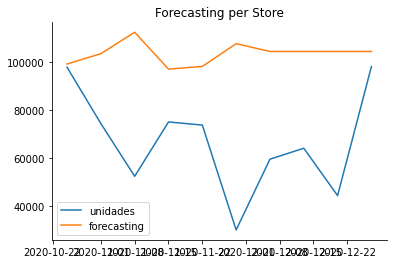

In [66]:
data_aux = data[data["almacen"]=="XXA"][["last_weekday", "unidades", "forecasting"]]
data_aux = data_aux.groupby("last_weekday")[["unidades", "forecasting"]].sum()
plt.figure()
plt.plot(data_aux["unidades"])
plt.plot(data_aux["forecasting"])
plt.title("Forecasting per Store")
plt.legend(["unidades", "forecasting"]);

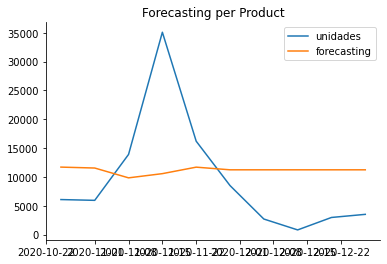

In [67]:
data_aux = data[data["producto"]=="XXNjiie"][["last_weekday", "unidades", "forecasting"]]
data_aux = data_aux.groupby("last_weekday")[["unidades", "forecasting"]].sum()
plt.figure()
plt.title("Forecasting per Product")
plt.plot(data_aux["unidades"])
plt.plot(data_aux["forecasting"])
plt.legend(["unidades", "forecasting"]);

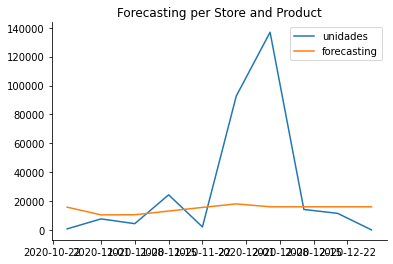

In [68]:
data_aux = data[(data["producto"]=="XXNjbji") & (data["almacen"] == "XXC")][["last_weekday", "unidades", "forecasting"]]
data_aux = data_aux.groupby("last_weekday")[["unidades", "forecasting"]].sum()
plt.figure()
plt.title("Forecasting per Store and Product")
plt.plot(data_aux["unidades"])
plt.plot(data_aux["forecasting"])
plt.legend(["unidades", "forecasting"]);

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "2.4."></a>
# 2.4. DL Based Models

The data approach for this models is the same than for the ML approach

In [120]:
def dnn_model(X, Y):
    """Densely connected neural network.
    
    Parameters
    ----------
        X np.array:
            Train data.
        
        Y np.array:
            Target train data.
            
    Returns
    -------
        tuple:
            first items is the model fitted and sencond item is the history across epochs.
    
    """
    X = np.asarray(X[:, 1:]).astype('float64')
    dnn = Sequential([
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dropout(.2),
    Dense(1, activation="relu")
    ])
    dnn.compile(loss='mse', optimizer='adam')
    hist = dnn.fit(X, Y, epochs=10, batch_size=32)
    return dnn, hist

def cnn_model(X, Y):
    """Convolutional neural network.
    
    Parameters
    ----------
        X np.array:
            Train data.
        
        Y np.array:
            Target train data.
            
    Returns
    -------
        tuple:
            first items is the model fitted and sencond item is the history across epochs.
    
    """
    X = np.asarray(X[:, 1:]).astype('float64')
    cnn = Sequential([
        Conv1D(32, kernel_size=4),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(16, kernel_size=4),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(8, kernel_size=4),
        BatchNormalization(),
        Activation("relu"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation="relu"),
        Dense(1, activation="relu")
    ])
    cnn.compile(loss='mse', optimizer='adam')
    hist = cnn.fit(X, Y, epochs=10, batch_size=32)
    return cnn, hist

def preprocessing_data(train, test, model="dnn"):
    """Function to prepare the data to train.
    
    Parameters
    ----------
        train pd.DataFrame:
            Data to train.
            
        test pd.DataFrame:
            Data to test.
        
        model str:
            Modelo to implement the process. Available only 'dnn' or 'cnn'.
            
    Returns
    -------
        tuple:
            Tuple with 4 items in this order, features train, target train, 
            features test, target test.
    
    """
    col_stores = [f"x0_{store}" for store in train["almacen"].unique()]
    col_products = [f"x0_{product}" for product in train["producto"].unique()]
    col_lags = [f"lag{n}" for n in range(1, 13)]
    
    # Apply a PCA over dummie columns and a MinMaxScaler over lag data for train and test.
    pca = PCA(.9)
    mm = MinMaxScaler((0, 1))
    X_pca = pca.fit_transform(train[col_stores + col_products])
    X_test_pca = pca.transform(test[col_stores + col_products])
    X_lags = mm.fit_transform(train[col_lags])
    X_test_lags = mm.transform(test[col_lags])
    X_train = np.concatenate((X_lags, X_pca), axis=1)
    X_test = np.concatenate((X_test_lags, X_test_pca), axis=1)
    Y_train = train[["unidades"]].values
    Y_test = test[["unidades"]].values
    
    # In case we have selected 'cnn' model reshape the data accordingly.
    if model == "cnn":
        # Add date column to filter.
        X_train = np.concatenate((train[["last_weekday"]].astype(str).values, X_train), axis=1)
        X_test = np.concatenate((test[["last_weekday"]].astype(str).values, X_test), axis=1)
        
        X_train_shape = X_train.shape
        Y_train_shape = Y_train.shape
        X_train = X_train.reshape((X_train_shape[0], X_train_shape[1], 1))
        Y_train = Y_train.reshape((Y_train_shape[0], Y_train_shape[1], 1))
        
        X_test_shape = X_test.shape
        Y_test_shape = Y_test.shape
        X_test = X_test.reshape((X_test_shape[0], X_test_shape[1], 1))
        Y_test = Y_test.reshape((Y_test_shape[0], Y_test_shape[1], 1))
        
    else:
        # Add date column to filter.
        X_train = np.concatenate((train[["last_weekday"]].astype(str).values, X_train), axis=1)
        X_test = np.concatenate((test[["last_weekday"]].astype(str).values, X_test), axis=1)
    
    return X_train, Y_train, X_test, Y_test

def dl_forecast(model, test, date_range):
    """Forecast time steps one by one for de DL approach.
    
    The proccess of forecasting in a ml approach is to predict next step time
    and the use this as a lag for the following steps.
    
    Parameters
    ----------
        model:
            Fitted pipeline to predict next time step.
        
        test np.array:
            Data used to test a model.
        
        date_range list:
            List of dates to predict next step.
    
    Returns
    -------
        tuple(np.array, np.array):
            Data with a 'forecasting' column that takes into account the steps time. And 
            the second item is the forecasting only in one step.
    
    """
    # Generate a empty list to fill with the lags for the following steps.
    lags = []
    
    # Generate a empty list to fill with the forecasting
    forecasted_array = []
    
    all_feat = np.asarray(test[:, 1:-1]).astype('float64')
    fcast_per_one_step_time = model.predict(all_feat)
    
    # For loop to predict each step time one by one
    for forecasting_step, date in enumerate(date_range):
        aux = test[test[:, 0] == date]
        if forecasting_step != 0:
            # In this step we are changing the lags of the following steps time 
            # with the previous forecasting.
            for lagn, lag_item in enumerate(lags[:10], 1):
                aux[:, 1:12] = np.concatenate((lag_item, aux[:, 1:(11)]), axis=1)
                #aux[:, lagn] = lag_item.reshape(lag_item.shape[0])                
        
        feat = np.asarray(aux[:, 1:-1]).astype('float64')
        forecasting = model.predict(feat)
        
        # Insert the forecasting into the lags list at the begining becase at each
        # step time lags move one step time.
        lags.insert(0, forecasting)
        aux = np.concatenate((aux, forecasting), axis=1)
        forecasted_array.append(aux)
        
    return np.concatenate(forecasted_array), fcast_per_one_step_time

def execute_dl_models(model="dnn"):
    """Function to execute available models for the DL approach on each fold.
    
    Available models are 'dnn' and 'cnn'.
    
    Parameters
    ----------
        model str:
            model to execute.
            
    Returns
    -------
        dict:
            dictionary with model name as a key and as a value a list with the mean, std
            of the rmse one each step time across folds, mean and std on train step 
            across folds and mean and std of one step time test across folds.
    
    """
    rmse_hist = []
    rmse_one = []
    rmse = []
    for fold in kfolds:
        train = fold[0]
        test = fold[1]
        date_range = [date for date in test["last_weekday"].astype(str).unique()]
        
        X, Y, x, y = preprocessing_data(train, test, model)
        xy = np.concatenate((x, y), axis=1)
        
        # Choose the model to train.
        if model == "dnn":
            mdl, hist = dnn_model(X, Y)
        elif model == "cnn":
            mdl, hist = cnn_model(X, Y)
        
        # Forecast values.
        fcast, fcast_one_step = dl_forecast(mdl, xy, date_range)
        
        # Calculate RMSE
        df = pd.DataFrame({"fore": fcast[:, -1]})
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
        rmse_hist.append(np.sqrt(hist.history.get("loss")[-1]))
        rmse_one.append(np.sqrt(mean_squared_error(y, fcast_one_step)))
        rmse.append(np.sqrt(mean_squared_error(fcast[:, -2], df["fore"].values)))
    
    return {f"{model}": [np.mean(rmse), np.std(rmse), 
                         np.mean(rmse_hist), np.std(rmse_hist),
                         np.mean(rmse_one), np.std(rmse_one)]}

In [121]:
dl_summary = {}
for m in ["dnn"]:
    ti = time.time()
    dl_summary = {**dl_summary, **execute_dl_models(m)}
    print("#"*10)
    print(f"{m} in time {time.time() - ti}")

Epoch 1/10
6257/6257 [==============================] - 14s 2ms/step - loss: 43590956.0000
Epoch 2/10
6257/6257 [==============================] - 15s 2ms/step - loss: 26145826.0000
Epoch 3/10
6257/6257 [==============================] - 13s 2ms/step - loss: 22640262.0000
Epoch 4/10
6257/6257 [==============================] - 13s 2ms/step - loss: 18408030.0000
Epoch 5/10
6257/6257 [==============================] - 15s 2ms/step - loss: 15665320.0000
Epoch 6/10
6257/6257 [==============================] - 15s 2ms/step - loss: 14901750.0000
Epoch 7/10
6257/6257 [==============================] - 14s 2ms/step - loss: 12817592.0000
Epoch 8/10
6257/6257 [==============================] - 14s 2ms/step - loss: 12574817.0000
Epoch 9/10
6257/6257 [==============================] - 13s 2ms/step - loss: 14907082.0000
Epoch 10/10
6257/6257 [==============================] - 17s 3ms/step - loss: 15319917.0000
Epoch 1/10
6314/6314 [==============================] - 14s 2ms/step - loss: 40375420.000

In [122]:
dl_summary

{'dnn': [6.522731291052103e+36,
  1.2975927264902593e+37,
  3261.372821053553,
  336.2836928743187,
  4528.454685891027,
  361.30541156149064]}

<a href="#toc"><p style="text-align:right;" href="#toc">Back To Table Of Contents</p></a> 
<a id = "3."></a>
# 3. Model Selection

After this analysis we can say that the best approach is the ML approach due to the RMSE at 10 time steps is the lowest.

In [99]:
last_fold = pd.concat([kfolds[-1][0], kfolds[-1][1]])

In [100]:
models = [
    (LGBMRegressor(n_estimators=100, max_depth=10, n_jobs=-1), 1, True)
]

summ_last = {}
for model in models:
    ti = time.time()
    summ_last = {**summ_last, **execute_model(model[0], model[1], model[2], [(last_fold, kfolds[-1][-1])], True)}
    print("#"*10)
    print(f"{model.__str__()} in time {time.time() - ti}")

##########
(LGBMRegressor(max_depth=10), 1, True) in time 35.61240315437317


In [101]:
summ_last

{'LGBMRegressor(max_depth=10) 1 True': [3747.9896755535065,
  0.0,
  2388.907360611566,
  0.0,
  3153.269931282294,
  0.0,
       almacen producto last_weekday  unidades          lag1          lag2  \
  0        XXA  XXLjcfd   2020-10-25   10000.0      0.000000      0.000000   
  10       XXA  XXLjgab   2020-10-25       0.0      0.000000      0.000000   
  20       XXA  XXLjiaa   2020-10-25       0.0      0.000000      0.000000   
  30       XXA  XXNaaae   2020-10-25       0.0      0.000000      0.000000   
  40       XXA  XXNaaaf   2020-10-25       0.0      0.000000      0.000000   
  ...      ...      ...          ...       ...           ...           ...   
  5759     XXI  XXNjiia   2020-12-27   25000.0  38861.194469  27285.642547   
  5769     XXJ  XXNjfeb   2020-12-27    2448.0   2232.808835   1632.396039   
  5779     XXJ  XXNjfec   2020-12-27       0.0    990.267104    782.444098   
  5789     XXJ  XXNjffd   2020-12-27       0.0   1005.376312    684.685520   
  5799     XXJ  XXN

In [109]:
pipe = summ_last.get("LGBMRegressor(max_depth=10) 1 True")[-1]

In [103]:
pred_fold = last_fold[last_fold["last_weekday"] == last_fold["last_weekday"].max()]
pred_fold.shape

(558, 344)

In [104]:
df_concat_list = []
for d in range(10):
    lf = pred_fold.copy()
    if d == 0:
        df_concat_list.append(lf)
    else:
        lf["last_weekday"] = lf["last_weekday"] + datetime.timedelta(days=7*d)
        df_concat_list.append(lf)

pred_fold = pd.concat(df_concat_list)

In [105]:
pred_fold.shape

(5580, 344)

In [106]:
pred_fold.head(2)

,almacen,producto,last_weekday,unidades,lag1,lag2,lag3,lag4,lag5,lag6,...,x0_XXNjiie,x0_XXNjjdf,x0_XXNjjeh,x0_XXNjjfc,x0_XXNjjfd,x0_XXNjjff,x0_XXNjjfj,x0_XXNjjgc,x0_XXNjjgd,x0_XXNjjha
9,XXA,XXLjcfd,2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,XXA,XXLjgab,2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
col_stores = [f"x0_{store}" for store in last_fold["almacen"].unique()]
col_products = [f"x0_{product}" for product in last_fold["producto"].unique()]

In [114]:
fcast_end = forecast(pipe, pred_fold, col_lags + col_stores + col_products)

In [116]:
fcast_end.to_csv("../DATA/results.csv", index=False)